In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
import wandb

api = wandb.Api()
entity = "disco-conv-splade"   # from your code
project = "disco-conv-splade_evaluation"

runs = api.runs(f"{entity}/{project}")

run_list = []
for run in runs:
    if "ckpt" in ast.literal_eval(run.config["config"])['out_dir']:
        run_list.append(run)
    if "cast20" in ast.literal_eval(run.config["config"])['index_dir'].split('/'):
        run_list.append(run)
df_list = []

for run in run_list:
    # convert summary (dict-like) to DataFrame with one row
    tmp_df = pd.DataFrame([dict(run.summary)])
    
    # extract run_name from config
    config_dict = ast.literal_eval(run.config["config"])
    try:
        if "cast20/mrr_10" in tmp_df.columns:
            run_checkpoint = 0
            run_name = config_dict['checkpoint_dir'].split('/')[-2] + "_cast20"
        else:
            run_checkpoint = int(config_dict['checkpoint_dir'].split('-')[-1])
            run_name = config_dict['checkpoint_dir'].split('/')[-2]
        tmp_df['run_name'] = run_name
        tmp_df['run_checkpoint'] = run_checkpoint
        df_list.append(tmp_df)
    except:
        pass


# concatenate all rows into a single DataFrame
runs_df = pd.concat(df_list, ignore_index=True)

runs_df.head()
# Filter metric columns
metric_cols = [col for col in runs_df.columns if col.startswith("TOPIOCQA/")]

# Sort by run_name
runs_df = runs_df.sort_values(by="run_checkpoint")

# for the checkpoints, if the run_name contains _00, multiply run_checkpoint by 2
runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if '_0' in row['run_name'] else row['run_checkpoint'],
    axis=1
)
runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if 'standard' in row['run_name'] else row['run_checkpoint'],
    axis=1
)

runs_df['run_checkpoint'] = runs_df.apply(
    lambda row: row['run_checkpoint'] * 2 if '1_neg' in row['run_name'] else row['run_checkpoint'],
    axis=1
)

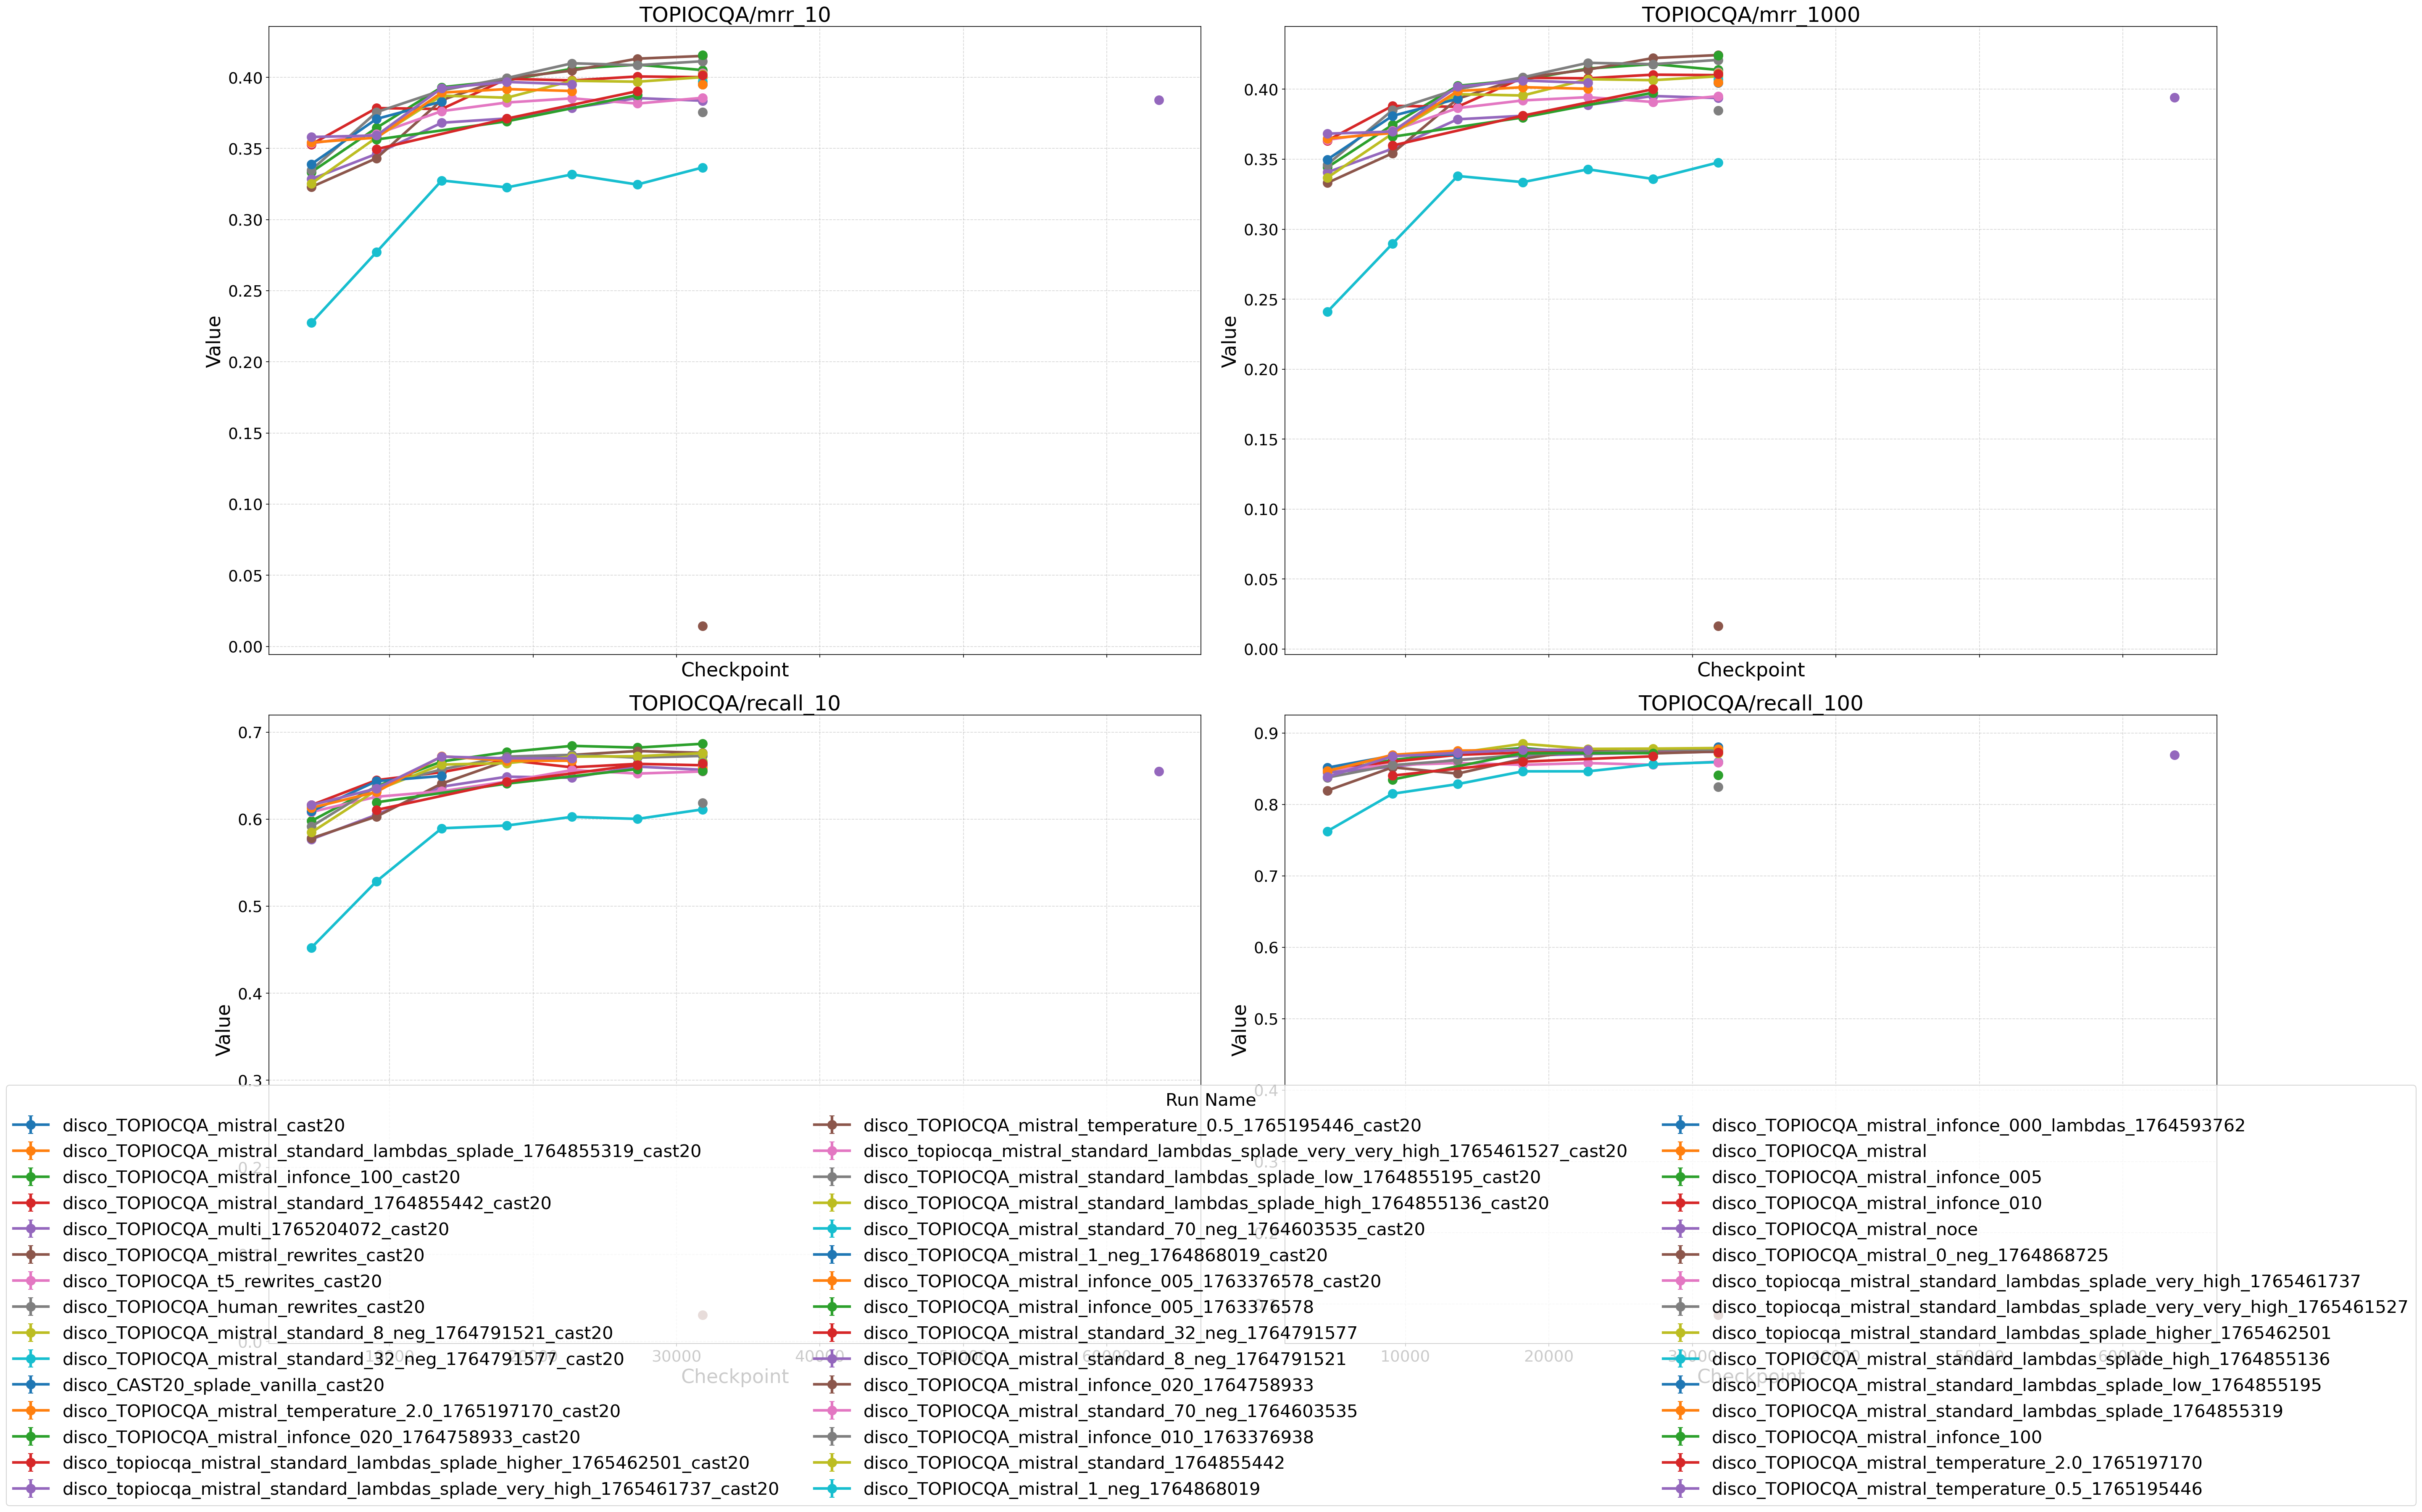

In [113]:
runs_df = runs_df[~runs_df.run_name.str.contains("3636")]
runs_df = runs_df[~runs_df.run_name.str.contains("6458")]
runs_df["runtime"] = runs_df["_wandb"].apply(lambda d: d.get("runtime"))

mask_cast20 = runs_df["run_name"].str.contains("cast20", case=False, na=False)

# keep cast20 runs OR runs with runtime > 3
runs_df = runs_df[ mask_cast20 | (runs_df["runtime"] > 3) ]


metrics_to_plot = [
    "TOPIOCQA/mrr_10",
    "TOPIOCQA/mrr_1000",
    "TOPIOCQA/recall_10",
    "TOPIOCQA/recall_100",
]

run_names = runs_df["run_name"].unique()

# ---- NEW: aggregate by run & checkpoint (multiple seeds) ----
agg_df = (
    runs_df
    .groupby(["run_name", "run_checkpoint"])
    .agg({metric: ["mean", "std"] for metric in metrics_to_plot})
)

# flatten multi-index columns
agg_df.columns = [f"{metric}_{stat}" for metric, stat in agg_df.columns]
agg_df = agg_df.reset_index()

plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 24,
    "axes.labelsize": 22,
    "legend.fontsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "lines.linewidth": 3,
    "lines.markersize": 10,
})

fig, axes = plt.subplots(
    2, 2, figsize=(32, 22), dpi=150, sharex=True, constrained_layout=True
)
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):

    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    for run in run_names:
        df_subset = agg_df[agg_df["run_name"] == run].sort_values("run_checkpoint")

        ax.errorbar(
            df_subset["run_checkpoint"],
            df_subset[mean_col],
            yerr=df_subset[std_col],
            marker="o",
            linestyle="-",
            capsize=3,
            label=run
        )

    ax.set_title(metric)
    ax.set_xlabel("Checkpoint")
    ax.set_ylabel("Value")
    ax.grid(True, linestyle="--", alpha=0.5)

# Legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Run Name",
    loc="lower center",
    ncol=3,
    bbox_to_anchor=(0.5, -0.09)  # adjust this value if you want it lower or higher
)
plt.show()

In [114]:
selection_neg_sampling = [
    "disco_TOPIOCQA_mistral_temperature_2.0_1765197170",
    "disco_TOPIOCQA_mistral_temperature_0.5_1765195446",
    "disco_TOPIOCQA_mistral_standard_1764855442",
]

metric_list = [
    "TOPIOCQA/mrr_1000",
    "TOPIOCQA/recall_10",
    "TOPIOCQA/recall_100",
    "TOPIOCQA/ndcg@3",
]

# --- original TOPIOCQA subset ---
df_subset = (
    runs_df.loc[
        runs_df["run_name"].isin(selection_neg_sampling)
        & (runs_df.run_checkpoint >= 31808),
        ["run_name"] + metric_list
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# --- CAST20 subset ---
cast20_names = [name + "_cast20" for name in selection_neg_sampling]
cast20_metrics = [m.replace("TOPIOCQA/", "cast20/") for m in metric_list]

df_cast20 = (
    runs_df.loc[
        runs_df["run_name"].isin(cast20_names),
        ["run_name"] + cast20_metrics
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# --- round floats for both ---
df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)

# --- rename CAST20 columns so the tables align vertically ---
df_cast20.columns = ["run_name"] + metric_list

# --- final concatenated output ---
df_final = pd.concat([df_subset, df_cast20], axis=0)

print(df_final.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
run_name & TOPIOCQA/mrr_1000 & TOPIOCQA/recall_10 & TOPIOCQA/recall_100 & TOPIOCQA/ndcg@3 \\
\midrule
disco_TOPIOCQA_mistral_standard_1764855442 & 0.409 & 0.676 & 0.879 & 0.396 \\
disco_TOPIOCQA_mistral_temperature_0.5_1765195446 & 0.394 & 0.655 & 0.870 & 0.379 \\
disco_TOPIOCQA_mistral_temperature_2.0_1765197170 & 0.411 & 0.664 & 0.873 & 0.399 \\
disco_TOPIOCQA_mistral_standard_1764855442_cast20 & 0.109 & 0.250 & 0.591 & 0.087 \\
disco_TOPIOCQA_mistral_temperature_0.5_1765195446_cast20 & 0.105 & 0.260 & 0.601 & 0.072 \\
disco_TOPIOCQA_mistral_temperature_2.0_1765197170_cast20 & 0.091 & 0.207 & 0.538 & 0.068 \\
\bottomrule
\end{tabular}



/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/328158820.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/328158820.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


In [115]:
df_cast20

,run_name,TOPIOCQA/mrr_1000,TOPIOCQA/recall_10,TOPIOCQA/recall_100,TOPIOCQA/ndcg@3
228,disco_TOPIOCQA_mistral_standard_1764855442_cast20,0.109,0.250,0.591,0.087
233,disco_TOPIOCQA_mistral_temperature_0.5_1765195...,0.105,0.260,0.601,0.072
231,disco_TOPIOCQA_mistral_temperature_2.0_1765197...,0.091,0.207,0.538,0.068


In [116]:
selection_neg_sampling = [
    "disco_TOPIOCQA_mistral_1_neg_1764868019", 
    "disco_TOPIOCQA_mistral_standard_70_neg_1764603535", 
    "disco_TOPIOCQA_mistral_standard_8_neg_1764791521", 
    "disco_TOPIOCQA_mistral_standard_32_neg_1764791577", 
    "disco_TOPIOCQA_mistral_standard_1764855442"
]

metric_list = [
    "TOPIOCQA/mrr_1000", 
    "TOPIOCQA/recall_10",  
    "TOPIOCQA/recall_100", 
    "TOPIOCQA/ndcg@3"
]

# ---------------------- TOPIOCQA subset ----------------------
df_subset = (
    runs_df.loc[
        runs_df["run_name"].isin(selection_neg_sampling)
        & (runs_df.run_checkpoint == 31808),
        ["run_name"] + metric_list
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# --- apply your custom name-to-int mapping ---
def map_name_to_int(name):
    if "1764855442" in name:
        return 16
    return int(name.split("_")[-3])

df_subset["run_name"] = df_subset["run_name"].apply(map_name_to_int)
df_subset.sort_values("run_name", inplace=True)

# ---------------------- CAST20 subset ----------------------
cast20_names = [name + "_cast20" for name in selection_neg_sampling]
cast20_metrics = [m.replace("TOPIOCQA/", "cast20/") for m in metric_list]

df_cast20 = (
    runs_df.loc[
        runs_df["run_name"].isin(cast20_names),
        ["run_name"] + cast20_metrics
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# --- apply the SAME name-to-int mapping to CAST20 run names ---
df_cast20["run_name"] = df_cast20["run_name"].apply(lambda x: map_name_to_int(x.replace("_cast20", "")))

df_cast20.sort_values("run_name", inplace=True)

# --- round numbers ---
df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)

# --- rename CAST20 metric columns so table aligns ---
df_cast20.columns = ["run_name"] + metric_list

# ---------------------- CONCATENATE BOTH ----------------------
df_final = pd.concat([df_subset, df_cast20], axis=0)

print(df_final.to_latex(index=False))


\begin{tabular}{lllll}
\toprule
run_name & TOPIOCQA/mrr_1000 & TOPIOCQA/recall_10 & TOPIOCQA/recall_100 & TOPIOCQA/ndcg@3 \\
\midrule
1.000 & 0.348 & 0.613 & 0.859 & nan \\
1.000 & 0.348 & 0.609 & 0.860 & 0.327 \\
8.000 & 0.394 & 0.657 & 0.874 & 0.381 \\
16.000 & 0.409 & 0.676 & 0.879 & 0.396 \\
32.000 & 0.410 & 0.662 & 0.874 & 0.395 \\
70.000 & 0.395 & 0.655 & 0.860 & 0.381 \\
1.000 & 0.094 & 0.207 & 0.500 & 0.067 \\
8.000 & 0.098 & 0.202 & 0.548 & 0.077 \\
8.000 & 0.098 & 0.202 & 0.548 & 0.077 \\
16.000 & 0.109 & 0.250 & 0.591 & 0.087 \\
32.000 & 0.110 & 0.255 & 0.562 & 0.079 \\
32.000 & 0.110 & 0.255 & 0.567 & 0.079 \\
70.000 & 0.111 & 0.264 & 0.620 & 0.073 \\
\bottomrule
\end{tabular}



/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/2211959334.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/2211959334.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


In [117]:
selection_infonce = [
    "disco_TOPIOCQA_mistral_infonce_005_1763376578",
    "disco_TOPIOCQA_mistral_infonce_010_1763376938",
    "disco_TOPIOCQA_mistral_infonce_020_1764758933",
    "disco_TOPIOCQA_mistral_standard_1764855442",
    "disco_TOPIOCQA_mistral_infonce_100"
]

metric_list = [
    "TOPIOCQA/mrr_1000",
    "TOPIOCQA/recall_10",
    "TOPIOCQA/recall_100",
    "TOPIOCQA/ndcg@3"
]

# ------------------ TOPIOCQA subset ------------------
df_subset = (
    runs_df.loc[
        runs_df["run_name"].isin(selection_infonce)
        & (runs_df.run_checkpoint == 31808),
        ["run_name"] + metric_list
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# ----- extract InfoNCE value -----
def get_infonce_alpha(name):
    if "infonce_0" in name:
        raw = name.split("_")[-2]
        return float(raw[0] + "." + raw[1:])
    return 0.0

df_subset["Infonce"] = df_subset["run_name"].apply(get_infonce_alpha)

# ----- convert run_name into descriptive label -----
def convert_name(name):
    if "infonce" in name:
        raw = name.split("_")[-2]
        return "Disco KL-Divergence + " + raw[0] + "." + raw[1:] + " InfoNCE"
    return "standard"

df_subset["run_name"] = df_subset["run_name"].apply(convert_name)

# set the standard model to InfoNCE = 1.00 (your custom rule)
std_mask = df_subset["run_name"] == "standard"
if std_mask.any():
    df_subset.loc[std_mask, "Infonce"] = 1.00

# ------------------ CAST20 subset ------------------
cast20_names = [name + "_cast20" for name in selection_infonce]
cast20_metrics = [m.replace("TOPIOCQA/", "cast20/") for m in metric_list]

df_cast20 = (
    runs_df.loc[
        runs_df["run_name"].isin(cast20_names),
        ["run_name"] + cast20_metrics
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# extract "base" run name for the same mapping logic
def strip_cast20(name):
    return name.replace("_cast20", "")

df_cast20["Infonce"] = df_cast20["run_name"].apply(lambda x: get_infonce_alpha(strip_cast20(x)))
df_cast20["run_name"] = df_cast20["run_name"].apply(lambda x: convert_name(strip_cast20(x)))

# ------------------ rounding ------------------
df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)

# make CAST20 columns match TOPIOCQA column names
df_cast20.columns = ["run_name"] + metric_list + ["Infonce"]

# ------------------ combine + print ------------------
df_final = pd.concat([df_subset, df_cast20], axis=0)

print(df_final.to_latex(index=False))


\begin{tabular}{llllll}
\toprule
run_name & TOPIOCQA/mrr_1000 & TOPIOCQA/recall_10 & TOPIOCQA/recall_100 & TOPIOCQA/ndcg@3 & Infonce \\
\midrule
Disco KL-Divergence + 0.05 InfoNCE & 0.414 & 0.687 & 0.875 & 0.400 & 0.050 \\
Disco KL-Divergence + 0.10 InfoNCE & 0.421 & 0.673 & 0.877 & 0.408 & 0.100 \\
Disco KL-Divergence + 0.20 InfoNCE & 0.424 & 0.676 & 0.874 & 0.412 & 0.200 \\
Disco KL-Divergence + i.nfonce InfoNCE & 0.424 & 0.656 & 0.841 & 0.412 & 0.000 \\
standard & 0.409 & 0.676 & 0.879 & 0.396 & 1.000 \\
Disco KL-Divergence + 0.05 InfoNCE & 0.104 & 0.226 & 0.582 & 0.084 & 0.050 \\
Disco KL-Divergence + 0.20 InfoNCE & 0.102 & 0.197 & 0.548 & 0.074 & 0.200 \\
Disco KL-Divergence + i.nfonce InfoNCE & 0.095 & 0.173 & 0.457 & 0.077 & 0.000 \\
standard & 0.109 & 0.250 & 0.591 & 0.087 & 0.000 \\
\bottomrule
\end{tabular}



/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/1343982727.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_subset = df_subset.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/1343982727.py:72: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cast20 = df_cast20.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)


In [118]:
# ------------------ TOPIOCQA subset ------------------
selection_infonce = [
    "disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319",
    "disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195",
    "disco_TOPIOCQA_mistral_standard_1764855442",
    "disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136",
    "disco_topiocqa_mistral_standard_lambdas_splade_higher_1765462501",
    "disco_topiocqa_mistral_standard_lambdas_splade_very_high_1765461737",
    "disco_topiocqa_mistral_standard_lambdas_splade_very_very_high_1765461527"
]

metric_list = [
    "TOPIOCQA/mrr_1000",
    "TOPIOCQA/recall_10",
    "TOPIOCQA/recall_100",
    "TOPIOCQA/ndcg@3"
]

df_subset = (
    runs_df.loc[
        runs_df["run_name"].isin(selection_infonce)
        & (runs_df.run_checkpoint == 31808),
        ["run_name"] + metric_list
    ]
    .drop_duplicates()
    .dropna()
    .sort_values("run_name")
)

# renaming rules
df_subset["run_name"] = df_subset["run_name"].apply(
    lambda x: x.split("_")[-2] if "lambdas" in x else "Standard_Disco"
)

# manually fix the "medium" name
df_subset.iloc[1, df_subset.columns.get_loc("run_name")] = "medium"

# FLOPS
df_subset["FLOPS"] = [3.79, 3.14, 2.80, 3.53, 1.84, 1.37, 0.47]
# higher 1.843512920638082
# very high 1.368561461440829
# highest 0.47435315249227494

# higher 0.084992152798765
# very high 0.09334859747596252
# highest 0.56661435199176664

# ------------------ CAST20 subset ------------------
cast20_names = [name + "_cast20" for name in selection_infonce]

cast20_metrics = [
    "cast20/mrr_1000",
    "cast20/recall_10",
    "cast20/recall_100",
    "cast20/ndcg@3"
]

df_cast20 = (
    runs_df.loc[
        runs_df["run_name"].isin(cast20_names),
        ["run_name"] + cast20_metrics
    ]
    .drop_duplicates()
    .sort_values("run_name")
)

# match the renaming logic
df_cast20["run_name"] = df_cast20["run_name"].apply(
    lambda x: x.split("_")[-3] if "lambdas" in x else "Standard_Disco"
)

df_cast20.iloc[1, df_cast20.columns.get_loc("run_name")] = "medium"

# Same FLOPS as TOPIOCQA rows
df_cast20["FLOPS"] = [3.79, 3.14, 2.80, 3.53, 1.50, 1.11, 0.39]


# ------------------ Formatting ------------------
# format all numeric values
df_subset = df_subset.applymap(
    lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x
)

df_cast20 = df_cast20.applymap(
    lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x
)

# Print LaTeX output
print(df_subset.to_latex(index=False))
print(df_cast20.to_latex(index=False))


\begin{tabular}{llllll}
\toprule
run_name & TOPIOCQA/mrr_1000 & TOPIOCQA/recall_10 & TOPIOCQA/recall_100 & TOPIOCQA/ndcg@3 & FLOPS \\
\midrule
Standard_Disco & 0.409 & 0.676 & 0.879 & 0.396 & 3.790 \\
medium & 0.405 & 0.659 & 0.877 & 0.391 & 3.140 \\
high & 0.407 & 0.665 & 0.876 & 0.394 & 2.800 \\
low & 0.405 & 0.663 & 0.881 & 0.391 & 3.530 \\
higher & 0.412 & 0.667 & 0.872 & 0.398 & 1.840 \\
high & 0.412 & 0.662 & 0.859 & 0.394 & 1.370 \\
high & 0.385 & 0.619 & 0.825 & 0.371 & 0.470 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllll}
\toprule
run_name & cast20/mrr_1000 & cast20/recall_10 & cast20/recall_100 & cast20/ndcg@3 & FLOPS \\
\midrule
Standard_Disco & 0.109 & 0.250 & 0.591 & 0.087 & 3.790 \\
medium & 0.103 & 0.226 & 0.591 & 0.084 & 3.140 \\
high & 0.102 & 0.236 & 0.591 & 0.085 & 2.800 \\
low & 0.104 & 0.245 & 0.591 & 0.081 & 3.530 \\
higher & 0.106 & 0.216 & 0.567 & 0.085 & 1.500 \\
high & 0.105 & 0.207 & 0.572 & 0.093 & 1.110 \\
high & 0.076 & 0.168 & 0.486 & 0.057 & 0.390 

/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/265549147.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_subset = df_subset.applymap(
/var/folders/nb/j_h4xjxd1tl7g7169hm8cdnc0000gn/T/ipykernel_4014/265549147.py:84: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cast20 = df_cast20.applymap(


In [119]:
import json
import os
import numpy as np
from scipy.stats import ttest_rel


def compare_vs_first(metric_dict, first_key, correction="bonferroni", alpha=0.05):
    """
    Compare every system against the first_key in metric_dict.

    correction: "bonferroni" or "none"
    alpha: significance threshold (default 0.05)

    Returns:
        list of (system, t_stat, p_raw, p_corr, significant)
    """

    systems = [s for s in metric_dict.keys() if s != first_key]
    m = len(systems)  # Bonferroni divisor

    x_base = np.array(metric_dict[first_key])
    results = []

    for sys in systems:
        x_other = np.array(metric_dict[sys])

        t_stat, p_raw = ttest_rel(x_base, x_other)

        # Apply correction or not
        if correction == "bonferroni":
            p_corr = min(p_raw * m, 1.0)
        else:
            p_corr = p_raw

        significant = p_corr < alpha

        results.append((sys, t_stat, p_raw, p_corr, significant))

    return results


def print_vs_first_results(first_key, results, metric_name):
    print(f"\n===== {metric_name}: Baseline = {first_key} =====")
    print("Other System | t-stat | p-raw | p-corrected | Significant?")
    for sys, t, p_raw, p_corr, sig in results:
        print(f"{sys} | t={t:.4f} | p={p_raw:.4g} | p_corr={p_corr:.4g} | {sig}")


def extract_scores_for_metric(data, dataset, metric, num_queries):
    """Extracts the per-query scores for one metric."""
    scores = []

    missinglist = []
    if metric == "mrr_1000":
        m_dict = data[dataset]["mrr_1000"]
        for i in range(num_queries):
            try:
                scores.append(m_dict[str(i)]["recip_rank"])
            except:
                missinglist.append(i)
                pass

    elif metric == "ndcg@3":
        try:
            m_dict = data[dataset]["ndcg@3"]
        except:
            pass
        for i in range(num_queries):
            try:
                scores.append(m_dict[str(i)])
            except:
                missinglist.append(i)
                pass

    elif metric in ["recall_10", "recall_100"]:
        for i in range(num_queries):
            try:
                scores.append(data[dataset][str(i)][metric])
            except:
                missinglist.append(i)
                pass
    else:
        raise ValueError(f"Unknown metric: {metric}")

    return scores


def run_significance_tests(
    pathlist,
    metrics,
    extension="perf_all_datasets_full.json",
    dataset="TOPIOCQA",
    num_queries=2513,
    correction="bonferroni",     # NEW: "bonferroni" or "none"
    alpha=0.05                   # NEW: significance threshold
):
    """
    Compares all systems against the first system in pathlist.
    """

    metric_data = {m: {} for m in metrics}

    # Load scores for each system
    for basepath in pathlist:
        json_path = os.path.join(basepath, extension)
        with open(json_path, "r") as f:
            last_line = f.readlines()[-1].strip()
            data = json.loads(last_line)

        for metric in metrics:
            metric_data[metric][json_path] = extract_scores_for_metric(
                data, dataset, metric, num_queries
            )

    # Baseline = first model in pathlist
    baseline_path = os.path.join(pathlist[0], extension)

    # Run significance tests for each metric
    for metric in metrics:
        results = compare_vs_first(
            metric_data[metric],
            baseline_path,
            correction=correction,
            alpha=alpha,
        )
        print_vs_first_results(baseline_path, results, metric)

    return metric_data


In [121]:
metrics_to_test = ["mrr_1000", "ndcg@3", "recall_10", "recall_100"]

pathlist = [
    "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_higher_1765462501_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_high_1765461737_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_very_high_1765461527_out_123_ckpt15904"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05)

pathlist = [
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_1764855442_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_higher_1765462501_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_very_high_1765461737_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_very_very_high_1765461527_out_123"
]

metrics_to_test = ["mrr_1000", "ndcg@3", "recall_10", "recall_100"]


output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05, dataset="cast20")


===== mrr_1000: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904/perf_all_datasets_full.json | t=1.3314 | p=0.1832 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904/perf_all_datasets_full.json | t=0.6404 | p=0.522 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904/perf_all_datasets_full.json | t=1.3295 | p=0.1838 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_lambdas_splade_higher_1765462501_out_123_ckpt15904/perf_all_datasets_full.json | t=-0.5637 | p=0.573 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_high_1765461737_out_123_ckpt15904/perf_all_datasets_full.json | t=-0.5446 | p=0.5861 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_lambdas_splade

In [6]:
pathlist = [
    "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_1_neg_1764868019_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123_ckpt15904"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05)

pathlist = [
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_1764855442_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_1_neg_1764868019_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05, dataset="cast20")



===== mrr_1000: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_mistral_1_neg_1764868019_out_123_ckpt15904/perf_all_datasets_full.json | t=10.8554 | p=7.345e-27 | p_corr=2.938e-26 | True
../disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123_ckpt15904/perf_all_datasets_full.json | t=3.4134 | p=0.0006518 | p_corr=0.002607 | True
../disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123_ckpt15904/perf_all_datasets_full.json | t=-0.2078 | p=0.8354 | p_corr=1 | False
../disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123_ckpt15904/perf_all_datasets_full.json | t=3.1409 | p=0.001704 | p_corr=0.006816 | True

===== ndcg@3: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_mistral_1_neg_1764868019_out_123_ckp

In [7]:
pathlist = [
    "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123_ckpt15904",
    "../disco_TOPIOCQA_mistral_infonce_020_1764758933_out_123_ckpt15904"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05)

pathlist = [
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_1764855442_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123",
    # "../disco_CAST20_disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123",
    "../disco_CAST20_disco_TOPIOCQA_mistral_infonce_020_1764758933_out_123"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="bonferroni", alpha=0.05, dataset="cast20")


===== mrr_1000: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123_ckpt15904/perf_all_datasets_full.json | t=-1.1024 | p=0.2704 | p_corr=0.8111 | False
../disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123_ckpt15904/perf_all_datasets_full.json | t=-2.6733 | p=0.00756 | p_corr=0.02268 | True
../disco_TOPIOCQA_mistral_infonce_020_1764758933_out_123_ckpt15904/perf_all_datasets_full.json | t=-3.3008 | p=0.0009776 | p_corr=0.002933 | True

===== ndcg@3: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123_ckpt15904/perf_all_datasets_full.json | t=-0.9389 | p=0.3479 | p_corr=1 | False
../disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123_ckpt159

In [8]:
file = "../disco_TOPIOCQA_t5_out_123/perf_all_datasets_full.json"
with open(file, "r") as f:
    last_line = f.readlines()[-1].strip()
    data = json.loads(last_line)

data['TOPIOCQA']['0']

{'recall_5': 1.0,
 'recall_10': 1.0,
 'recall_15': 1.0,
 'recall_20': 1.0,
 'recall_30': 1.0,
 'recall_100': 1.0,
 'recall_200': 1.0,
 'recall_500': 1.0,
 'recall_1000': 1.0}

In [9]:
pathlist = [
    "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904",
    "../disco_TOPIOCQA_multi_out_123",
    "../disco_TOPIOCQA_splade_vanilla_out_123",
    "../disco_TOPIOCQA_t5_distil_out_123",
    "../disco_TOPIOCQA_t5_out_123",
    "../disco_TOPIOCQA_t5_rewrites_out_123"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="None", alpha=0.05)

pathlist = [
    "../disco_CAST20_disco_TOPIOCQA_mistral_standard_1764855442_out_123",
    "../disco_CAST20_fusion_out_123",
    "../disco_CAST20_human_rewrites_out_123",
    "../disco_CAST20_mistral_out_123",
    "../disco_CAST20_t5_rewrites_out_123",
    "../disco_CAST20_mistral_rewrites_out_123"
]

output = run_significance_tests(pathlist, metrics_to_test, correction="None", alpha=0.05, dataset="cast20")


===== mrr_1000: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_multi_out_123/perf_all_datasets_full.json | t=4.6613 | p=3.306e-06 | p_corr=3.306e-06 | True
../disco_TOPIOCQA_splade_vanilla_out_123/perf_all_datasets_full.json | t=32.3024 | p=9.325e-192 | p_corr=9.325e-192 | True
../disco_TOPIOCQA_t5_distil_out_123/perf_all_datasets_full.json | t=21.3665 | p=3.314e-93 | p_corr=3.314e-93 | True
../disco_TOPIOCQA_t5_out_123/perf_all_datasets_full.json | t=10.0814 | p=1.853e-23 | p_corr=1.853e-23 | True
../disco_TOPIOCQA_t5_rewrites_out_123/perf_all_datasets_full.json | t=11.0410 | p=1.04e-27 | p_corr=1.04e-27 | True

===== ndcg@3: Baseline = ../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/perf_all_datasets_full.json =====
Other System | t-stat | p-raw | p-corrected | Significant?
../disco_TOPIOCQA_multi_out_123/perf_all_datasets_full.js

In [48]:
import json
import os

student_similarity_score_lambdas_low_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904/"
student_similarity_score_lambdas_high_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904/"
student_similarity_score_lambdas_medium_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904/"
student_similarity_score_lambdas_higher_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_higher_1765462501_out_123_ckpt15904/"
student_similarity_score_lambdas_very_high_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_high_1765461737_out_123_ckpt15904/"
student_similarity_score_lambdas_very_very_high_results_run = "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_very_high_1765461527_out_123_ckpt15904/"
student_similarity_score_disco = "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/"

with open(os.path.join(student_similarity_score_lambdas_low_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_low_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_high_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_high_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_medium_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_medium_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_disco, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_disco_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_higher_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_higher_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_very_high_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_very_high_data = json.loads(first_line)

with open(os.path.join(student_similarity_score_lambdas_very_very_high_results_run, "perf_all_datasets_full.json"), "r") as f:
    first_line = f.readline().strip()
    student_similarity_score_lambdas_very_very_high_data = json.loads(first_line)


In [49]:
len_dict = {}
with open("DATA/topiocqa_topics/queries_rowid_dev_all.tsv", "r") as f:
    for idx, line in enumerate(f):
        line.strip().split("\t")[1]
        len_dict[idx] = int(line.count("[SEP]")/2)+1

# print the value counts of len_dict
from collections import Counter
len_counts = Counter(len_dict.values())
print(len_counts)

Counter({1: 205, 2: 205, 3: 205, 4: 205, 5: 205, 6: 205, 7: 205, 8: 205, 9: 205, 10: 205, 11: 149, 12: 114, 13: 89, 14: 59, 15: 43, 16: 10})


In [50]:
student_similarity_score_lambdas_low_data['TOPIOCQA']['1']

{'recall_5': 1.0,
 'recall_10': 1.0,
 'recall_15': 1.0,
 'recall_20': 1.0,
 'recall_30': 1.0,
 'recall_100': 1.0,
 'recall_200': 1.0,
 'recall_500': 1.0,
 'recall_1000': 1.0}

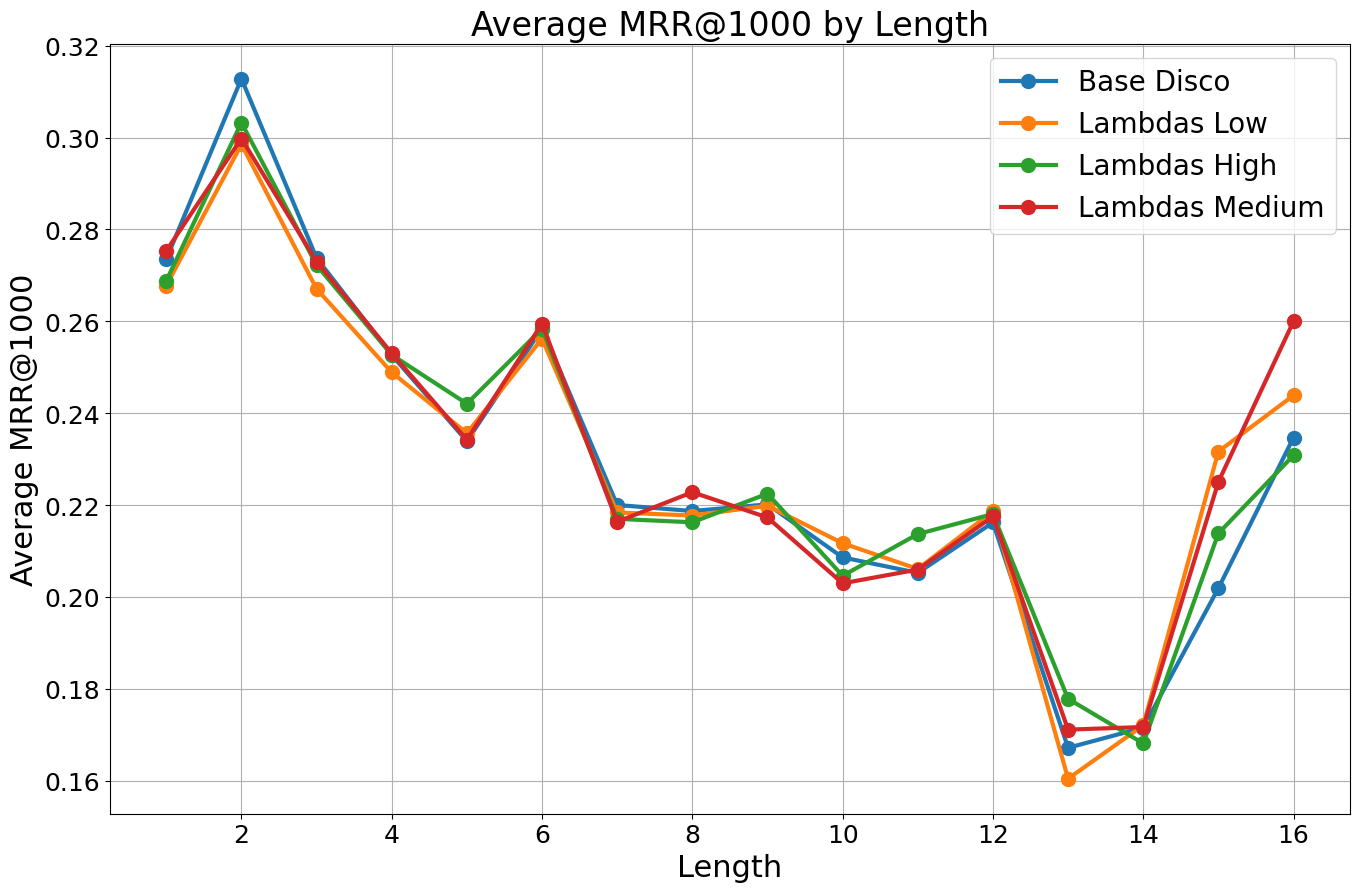

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib



def plot_avg_mrr_by_length(
    datasets, 
    len_dict, 
    labels, 
    save_path="fig.png",
    normalize=False
):
    """
    Plots average MRR@10 by length for multiple datasets, optionally normalized
    by subtracting each model's MRR at length 0.

    Args:
        datasets (list of dict): Each dict should have the same structure as base_disco_data['TOPIOCQA'].
        len_dict (dict): Mapping from sample index to length.
        labels (list of str): Labels for each dataset in the plot legend.
        save_path (str): Path to save the figure.
        normalize (bool): If True, subtract the MRR at length 0 for each dataset.
    """
    plt.figure(figsize=(16, 10))

    for data, label in zip(datasets, labels):
        mrr_values = []
        lengths = []

        for key, val in data['mrr_1000'].items():
            idx = int(key)
            mrr = val['recip_rank']
            length = len_dict.get(idx, None)
            if length is not None:
                mrr_values.append(mrr)
                lengths.append(length)

        df = pd.DataFrame({'length': lengths, 'mrr_1000': mrr_values})
        avg_df = df.groupby('length')['mrr_1000'].mean().reset_index()

        # ---- Normalization Step ----
        if normalize:
            if 0 in avg_df['length'].values:
                base_val = avg_df.loc[avg_df['length'] == 0, 'mrr_1000'].iloc[0]
                avg_df['mrr_1000'] = avg_df['mrr_1000'] - base_val
            else:
                print(f"Warning: length=0 not found for dataset '{label}', skipping normalization.")

        plt.plot(avg_df['length'], avg_df['mrr_1000'], marker='o', label=label)

    plt.xlabel('Length')
    plt.ylabel('Average MRR@1000' + (' (normalized)' if normalize else ''))
    plt.title('Average MRR@1000 by Length' + (' (Normalized)' if normalize else ''))
    plt.grid(True)
    plt.legend()
    plt.show()


plot_avg_mrr_by_length(
    datasets=[student_similarity_score_disco_data['TOPIOCQA'], student_similarity_score_lambdas_low_data['TOPIOCQA'], student_similarity_score_lambdas_high_data['TOPIOCQA'], student_similarity_score_lambdas_medium_data['TOPIOCQA']],
    len_dict=len_dict,
    labels=['Base Disco', 'Lambdas Low', 'Lambdas High', 'Lambdas Medium'],
    save_path="avg_mrr_comparison.png",
)


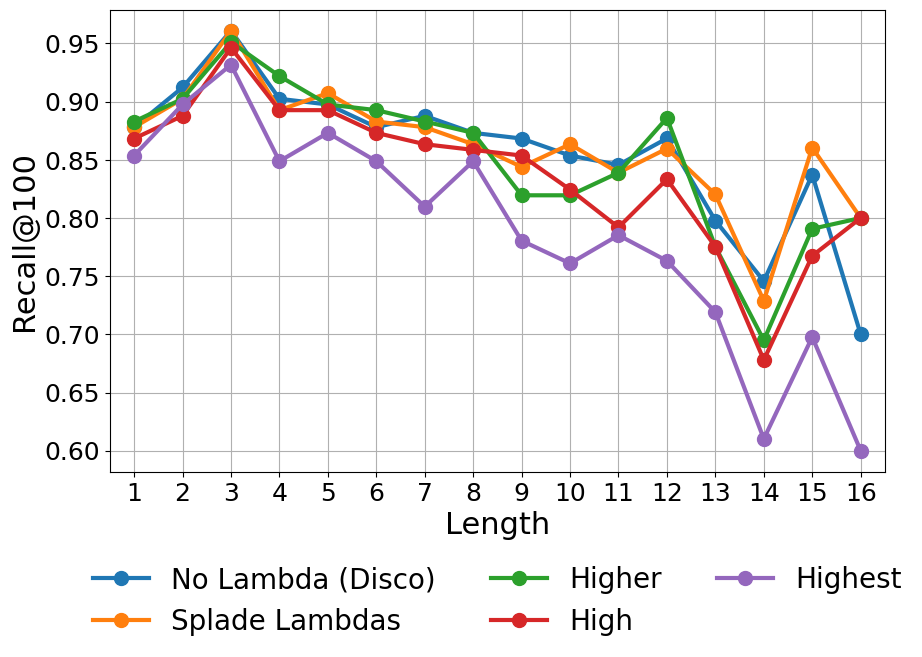

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib


def plot_avg_recall_by_length(
    datasets, 
    len_dict, 
    labels, 
    save_path="fig.png",
    normalize=False
):
    """
    Plots average Recall@100 by length for multiple datasets, optionally normalized
    by subtracting each model's Recall@100 at length 0.

    Args:
        datasets (list of dict): Each dict should have the same structure as base_disco_data['TOPIOCQA'].
        len_dict (dict): Mapping from sample index to length.
        labels (list of str): Labels for each dataset in the plot legend.
        save_path (str): Path to save the figure.
        normalize (bool): If True, subtract the Recall@100 at length 0 for each dataset.
    """
    plt.figure(figsize=(10, 6))

    for data, label in zip(datasets, labels):
        recall_values = []
        lengths = []

        for key, val in data.items():
            try: 
                idx = int(key)
                recall = val.get('recall_100', None)
            except:
                continue

            length = len_dict.get(idx, None)
            if length is not None and recall is not None:
                recall_values.append(recall)
                lengths.append(length)

        df = pd.DataFrame({'length': lengths, 'recall_100': recall_values})
        avg_df = df.groupby('length')['recall_100'].mean().reset_index()

        if normalize:
            if 0 in avg_df['length'].values:
                base_val = avg_df.loc[avg_df['length'] == 0, 'recall_100'].iloc[0]
                avg_df['recall_100'] = avg_df['recall_100'] - base_val
            else:
                print(f"Warning: length=0 not found for dataset '{label}', skipping normalization.")

        plt.plot(avg_df['length'], avg_df['recall_100'], marker='o', label=label)

    plt.xlabel('Length')
    plt.ylabel('Recall@100' + (' (normalized)' if normalize else ''))
    plt.grid(True)
    plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,          # adjust based on how many labels you want per row
    frameon=False
    )

    # --- Set x-axis to start at 1 and include 1 as a tick ---
    plt.xlim(left=0.5, right=16.5)
    plt.xticks(np.arange(1, 17))  # ensure 1 is included as a tick

    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.05)
    plt.show()


plot_avg_recall_by_length(
    datasets=[
        student_similarity_score_disco_data['TOPIOCQA'],  # No Lambda (Disco)
        # student_similarity_score_lambdas_low_data['TOPIOCQA'],  # Low
        student_similarity_score_lambdas_medium_data['TOPIOCQA'],  # Medium
        # student_similarity_score_lambdas_high_data['TOPIOCQA'],  # High
        student_similarity_score_lambdas_higher_data['TOPIOCQA'],  # Higher
        student_similarity_score_lambdas_very_high_data['TOPIOCQA'],  # Very High
        student_similarity_score_lambdas_very_very_high_data['TOPIOCQA'],  # Very Very High
    ],
    len_dict=len_dict,
    labels=['No Lambda (Disco)', 'Splade Lambdas', 'Higher', 'High', 'Highest'],
    save_path="avg_recall100_comparison.pdf",
)



In [53]:
teacher_similarity_score_file = "DATA/topiocqa_distil/distil_run_top_mistral.json"

with open(teacher_similarity_score_file, "r") as f:
    file = json.load(f)

In [54]:
import os
os.listdir("..")

['disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_infonce_010_1763376938_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_infonce_000_lambdas_1764593762_out_123_ckpt6816',
 'disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123_ckpt15904',
 'disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904',
 'disco_TOPIOCQA_splade_vanilla_out_123',
 '.DS_Store',
 'disco_CAST20_disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123',
 'disco_CAST20_disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123',
 'disco_CAST20_disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123',
 'disco_TOPIOCQA_t5_out_123',
 'disco_TOPIOCQA_mistral_rewrites_out_123',
 'disco_CAST20_disco_TOPIOCQA_mistral_infonce_005_1763376578_out_123',
 'disco_TOPIOCQA_mistral_standard_lambdas_splade_very_very_high_1765461527_out_123_ckpt15904',
 'disco_TOPIOCQA_t5_distil_out_123',
 'disco_TOPIOCQA_mistral_infonce_020_1764758933_out_123_ckpt15904',
 '

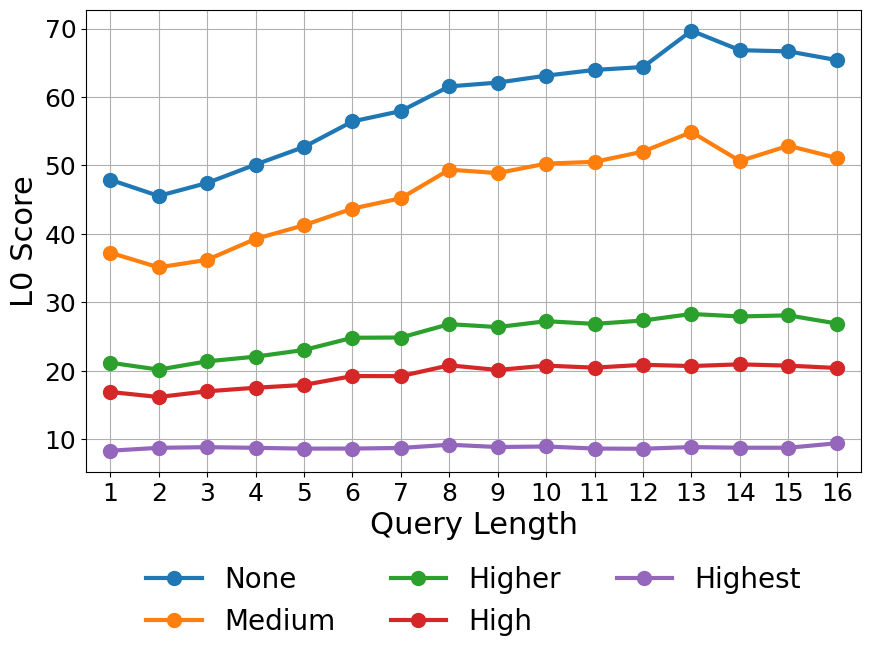

In [128]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# File paths
# -----------------------

paths = {
    "None": "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    # "Low":      "../disco_TOPIOCQA_mistral_standard_lambdas_splade_low_1764855195_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "Medium":   "../disco_TOPIOCQA_mistral_standard_lambdas_splade_1764855319_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    # "High":     "../disco_TOPIOCQA_mistral_standard_lambdas_splade_high_1764855136_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "Higher":   "../disco_TOPIOCQA_mistral_standard_lambdas_splade_higher_1765462501_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "High": "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_high_1765461737_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json",
    "Highest": "../disco_TOPIOCQA_mistral_standard_lambdas_splade_very_very_high_1765461527_out_123_ckpt15904/TOPIOCQA/stats/l0_stats_per_query.json"
}
# -----------------------
# Load JSON runs
# -----------------------
runs = {}
for name, path in paths.items():
    with open(path, "r") as f:
        runs[name] = json.load(f)

# -----------------------
# Helper: extract length + L0 for a run
# -----------------------
def extract_length_l0(results, len_dict):
    lengths = []
    l0_values = []
    
    for key, entry in results.items():
        try:
            idx = int(key)
        except:
            continue
        lengths.append(len_dict[idx])
        l0_values.append(entry)
    
    return pd.DataFrame({"length": lengths, "L0": l0_values})


# -----------------------
# Build DataFrames for each run
# -----------------------
df_runs = {}
for name, results in runs.items():
    df_runs[name] = extract_length_l0(results, len_dict)
    df_runs[name] = df_runs[name].groupby("length")["L0"].mean().reset_index()


# -----------------------
# Plot all runs together
# -----------------------
plt.figure(figsize=(10, 6))

for name, df in df_runs.items():
    plt.plot(df["length"], df["L0"], marker="o", label=name)

plt.xlabel("Query Length")
plt.ylabel("L0 Score")
plt.grid(True)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,          # adjust based on how many labels you want per row
    frameon=False
    )

plt.xlim(left=0.5, right=16.5)
plt.xticks(np.arange(1, 17))  # ensure 1 is included as a tick

plt.savefig("l0-values.pdf", bbox_inches='tight', pad_inches=0.05)
plt.show()


NameError: name 'results' is not defined

In [36]:
student_16 = "../disco_TOPIOCQA_mistral_standard_1764855442_out_123_ckpt15904"
student_1 = "../disco_TOPIOCQA_mistral_1_neg_1764868019_out_123_ckpt15904"
student_8 = "../disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123_ckpt15904"
student_32 = "../disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123_ckpt15904"
student_70 = "../disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123_ckpt15904"
teacher  = "../disco_TOPIOCQA_mistral_rewrites_out_123/"
with open(student_16 + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_16_results = json.loads(last_line)

with open(student_1 + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_1_results = json.loads(last_line)

with open(student_8 + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_8_results = json.loads(last_line)

with open(student_32 + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_32_results = json.loads(last_line)

with open(student_70 + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_70_results = json.loads(last_line)

with open(teacher + "/TOPIOCQA/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    teacher_results = json.loads(last_line)

In [37]:
import numpy as np

def kl_divergence(p, q):
    """Discrete KL divergence D_KL(p || q)."""
    return np.sum(p * np.log(p / q))

def hist_probs(arr, bins, eps=1e-12):
    """Convert array to a smoothed discrete probability distribution."""
    counts, _ = np.histogram(arr, bins=bins)
    probs = counts.astype(float) + eps
    probs /= probs.sum()
    return probs

# ------------------------------------------------------------------
# 1. Build flattened score arrays for ALL queries
# ------------------------------------------------------------------

min_queries = 1
max_queries = 2505

scores_teacher = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in teacher_results[str(i)].values()),
    dtype=float
)

scores_student_1 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_1_results[str(i)].values()),
    dtype=float
)

scores_student_8 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_8_results[str(i)].values()),
    dtype=float
)

scores_student_16 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_16_results[str(i)].values()),
    dtype=float
)

scores_student_32 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_32_results[str(i)].values()),
    dtype=float
)

scores_student_70 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_70_results[str(i)].values()),
    dtype=float
)


models = {
    "Scores Teacher": scores_teacher,
    "Student 1": scores_student_1,
    "Student 8": scores_student_8,
    "Student 16": scores_student_16,
    "Student 32": scores_student_32,
    "Student 70": scores_student_70,
}

# ------------------------------------------------------------------
# 2. Build global bins across *all* models and the teacher
# ------------------------------------------------------------------

all_arrays = [scores_teacher] + list(models.values())
global_min = min(arr.min() for arr in all_arrays)
global_max = max(arr.max() for arr in all_arrays)

num_bins = 300
bins = np.linspace(global_min, global_max, num_bins + 1)

teacher_probs = hist_probs(scores_teacher, bins)

# ------------------------------------------------------------------
# 3. Compute KL divergence for each model
# ------------------------------------------------------------------

klds = {}

for name, arr in models.items():
    model_probs = hist_probs(arr, bins)
    klds[name] = kl_divergence(teacher_probs, model_probs)

# ------------------------------------------------------------------
# 4. Print results
# ------------------------------------------------------------------

print("\n=== KL Divergence Over ALL 2500 Queries ===\n")
for name, val in klds.items():
    print(f"D_KL(Teacher || {name:18}) = {val:.6f}")



=== KL Divergence Over ALL 2500 Queries ===

D_KL(Teacher || Scores Teacher    ) = 0.000000
D_KL(Teacher || Student 1         ) = 3.501053
D_KL(Teacher || Student 8         ) = 3.860677
D_KL(Teacher || Student 16        ) = 3.998035
D_KL(Teacher || Student 32        ) = 3.591652
D_KL(Teacher || Student 70        ) = 3.221404


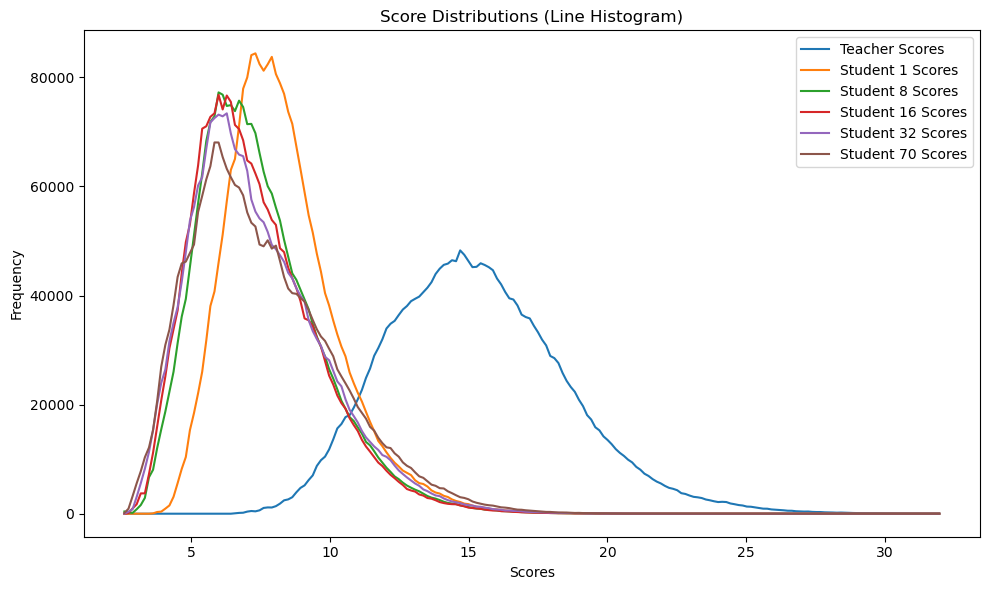

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten scores
min_queries = 1
max_queries = 2500




# Use many bins
num_bins = 200

# Compute a global range for consistent bins
min_score = min(scores_student_1.min(), scores_student_16.min(), scores_student_8.min(),
                scores_student_32.min(), scores_student_70.min())
max_score = max(scores_student_1.max(), scores_student_16.max(), scores_student_8.max(),
                scores_student_32.max(), scores_student_70.max())

bins = np.linspace(min_score, max_score, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def hist_line(data):
    counts, _ = np.histogram(data, bins=bins)
    return counts

plt.figure(figsize=(10, 6))

plt.plot(bin_centers, hist_line(scores_teacher), label="Teacher Scores")
plt.plot(bin_centers, hist_line(scores_student_1), label="Student 1 Scores")
plt.plot(bin_centers, hist_line(scores_student_8), label="Student 8 Scores")
plt.plot(bin_centers, hist_line(scores_student_16), label="Student 16 Scores")
plt.plot(bin_centers, hist_line(scores_student_32), label="Student 32 Scores")
plt.plot(bin_centers, hist_line(scores_student_70), label="Student 70 Scores")
# plt.plot(bin_centers, hist_line(scores_train), label="Teacher Train Scores")

plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Score Distributions (Line Histogram)")
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
student_16 = "../disco_CAST20_disco_TOPIOCQA_mistral_standard_1764855442_out_123"
student_1 = "../disco_CAST20_disco_TOPIOCQA_mistral_1_neg_1764868019_out_123"
student_8 = "../disco_CAST20_disco_TOPIOCQA_mistral_standard_8_neg_1764791521_out_123"
student_32 = "../disco_CAST20_disco_TOPIOCQA_mistral_standard_32_neg_1764791577_out_123"
student_70 = "../disco_CAST20_disco_TOPIOCQA_mistral_standard_70_neg_1764603535_out_123"
teacher = "../disco_CAST20_mistral_rewrites_out_123"

with open(student_16 + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_16_results = json.loads(last_line)

with open(student_1 + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_1_results = json.loads(last_line)

with open(student_8 + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_8_results = json.loads(last_line)

with open(student_32 + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_32_results = json.loads(last_line)

with open(student_70 + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    student_70_results = json.loads(last_line)

with open(teacher + "/cast20/run.json", "r") as f:
    last_line = f.readlines()[-1].strip()
    teacher_results = json.loads(last_line)

In [45]:
import numpy as np

def kl_divergence(p, q):
    """Discrete KL divergence D_KL(p || q)."""
    return np.sum(p * np.log(p / q))

def hist_probs(arr, bins, eps=1e-12):
    """Convert array to a smoothed discrete probability distribution."""
    counts, _ = np.histogram(arr, bins=bins)
    probs = counts.astype(float) + eps
    probs /= probs.sum()
    return probs

# ------------------------------------------------------------------
# 1. Build flattened score arrays for ALL queries
# ------------------------------------------------------------------

min_queries = 1
max_queries = 215

scores_teacher = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in teacher_results[str(i)].values()),
    dtype=float
)

scores_student_1 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_1_results[str(i)].values()),
    dtype=float
)

scores_student_8 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_8_results[str(i)].values()),
    dtype=float
)

scores_student_16 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_16_results[str(i)].values()),
    dtype=float
)

scores_student_32 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_32_results[str(i)].values()),
    dtype=float
)

scores_student_70 = np.fromiter(
    (v for i in range(min_queries, max_queries+1) for v in student_70_results[str(i)].values()),
    dtype=float
)


models = {
    "Scores Teacher": scores_teacher,
    "Student 1": scores_student_1,
    "Student 8": scores_student_8,
    "Student 16": scores_student_16,
    "Student 32": scores_student_32,
    "Student 70": scores_student_70,
}

# ------------------------------------------------------------------
# 2. Build global bins across *all* models and the teacher
# ------------------------------------------------------------------

all_arrays = [scores_teacher] + list(models.values())
global_min = min(arr.min() for arr in all_arrays)
global_max = max(arr.max() for arr in all_arrays)

num_bins = 300
bins = np.linspace(global_min, global_max, num_bins + 1)

teacher_probs = hist_probs(scores_teacher, bins)

# ------------------------------------------------------------------
# 3. Compute KL divergence for each model
# ------------------------------------------------------------------

klds = {}

for name, arr in models.items():
    model_probs = hist_probs(arr, bins)
    klds[name] = kl_divergence(teacher_probs, model_probs)

# ------------------------------------------------------------------
# 4. Print results
# ------------------------------------------------------------------

print("\n=== KL Divergence Over ALL 2500 Queries ===\n")
for name, val in klds.items():
    print(f"D_KL(Teacher || {name:18}) = {val:.6f}")



=== KL Divergence Over ALL 2500 Queries ===

D_KL(Teacher || Scores Teacher    ) = 0.000000
D_KL(Teacher || Student 1         ) = 4.679470
D_KL(Teacher || Student 8         ) = 6.784472
D_KL(Teacher || Student 16        ) = 7.805071
D_KL(Teacher || Student 32        ) = 6.563094
D_KL(Teacher || Student 70        ) = 6.667652


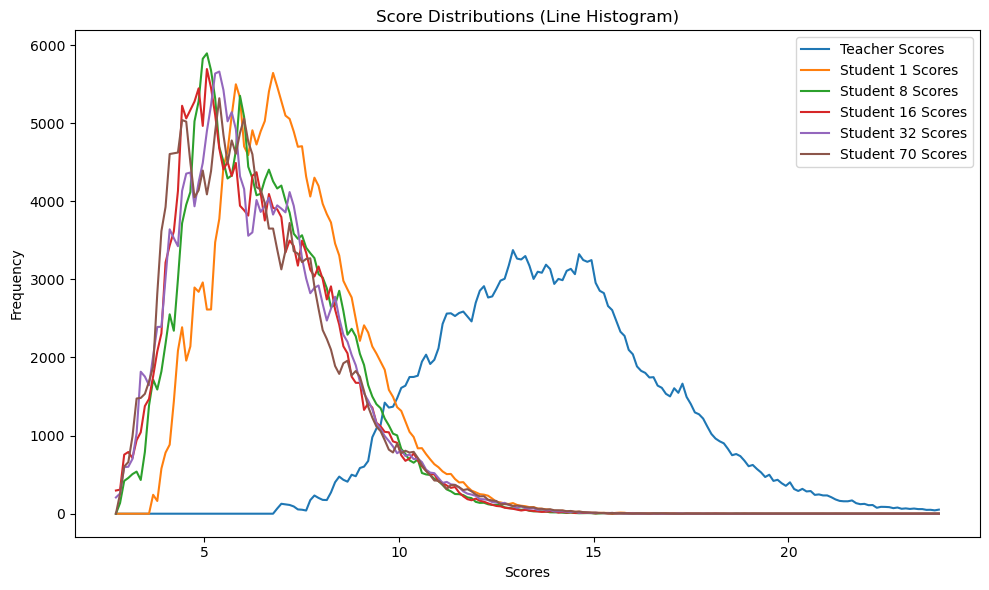

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten scores
min_queries = 1
max_queries = 2500




# Use many bins
num_bins = 200

# Compute a global range for consistent bins
min_score = min(scores_student_1.min(), scores_student_16.min(), scores_student_8.min(),
                scores_student_32.min(), scores_student_70.min())
max_score = max(scores_student_1.max(), scores_student_16.max(), scores_student_8.max(),
                scores_student_32.max(), scores_student_70.max())

bins = np.linspace(min_score, max_score, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def hist_line(data):
    counts, _ = np.histogram(data, bins=bins)
    return counts

plt.figure(figsize=(10, 6))

plt.plot(bin_centers, hist_line(scores_teacher), label="Teacher Scores")
plt.plot(bin_centers, hist_line(scores_student_1), label="Student 1 Scores")
plt.plot(bin_centers, hist_line(scores_student_8), label="Student 8 Scores")
plt.plot(bin_centers, hist_line(scores_student_16), label="Student 16 Scores")
plt.plot(bin_centers, hist_line(scores_student_32), label="Student 32 Scores")
plt.plot(bin_centers, hist_line(scores_student_70), label="Student 70 Scores")
# plt.plot(bin_centers, hist_line(scores_train), label="Teacher Train Scores")

plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Score Distributions (Line Histogram)")
plt.legend()
plt.tight_layout()
plt.show()


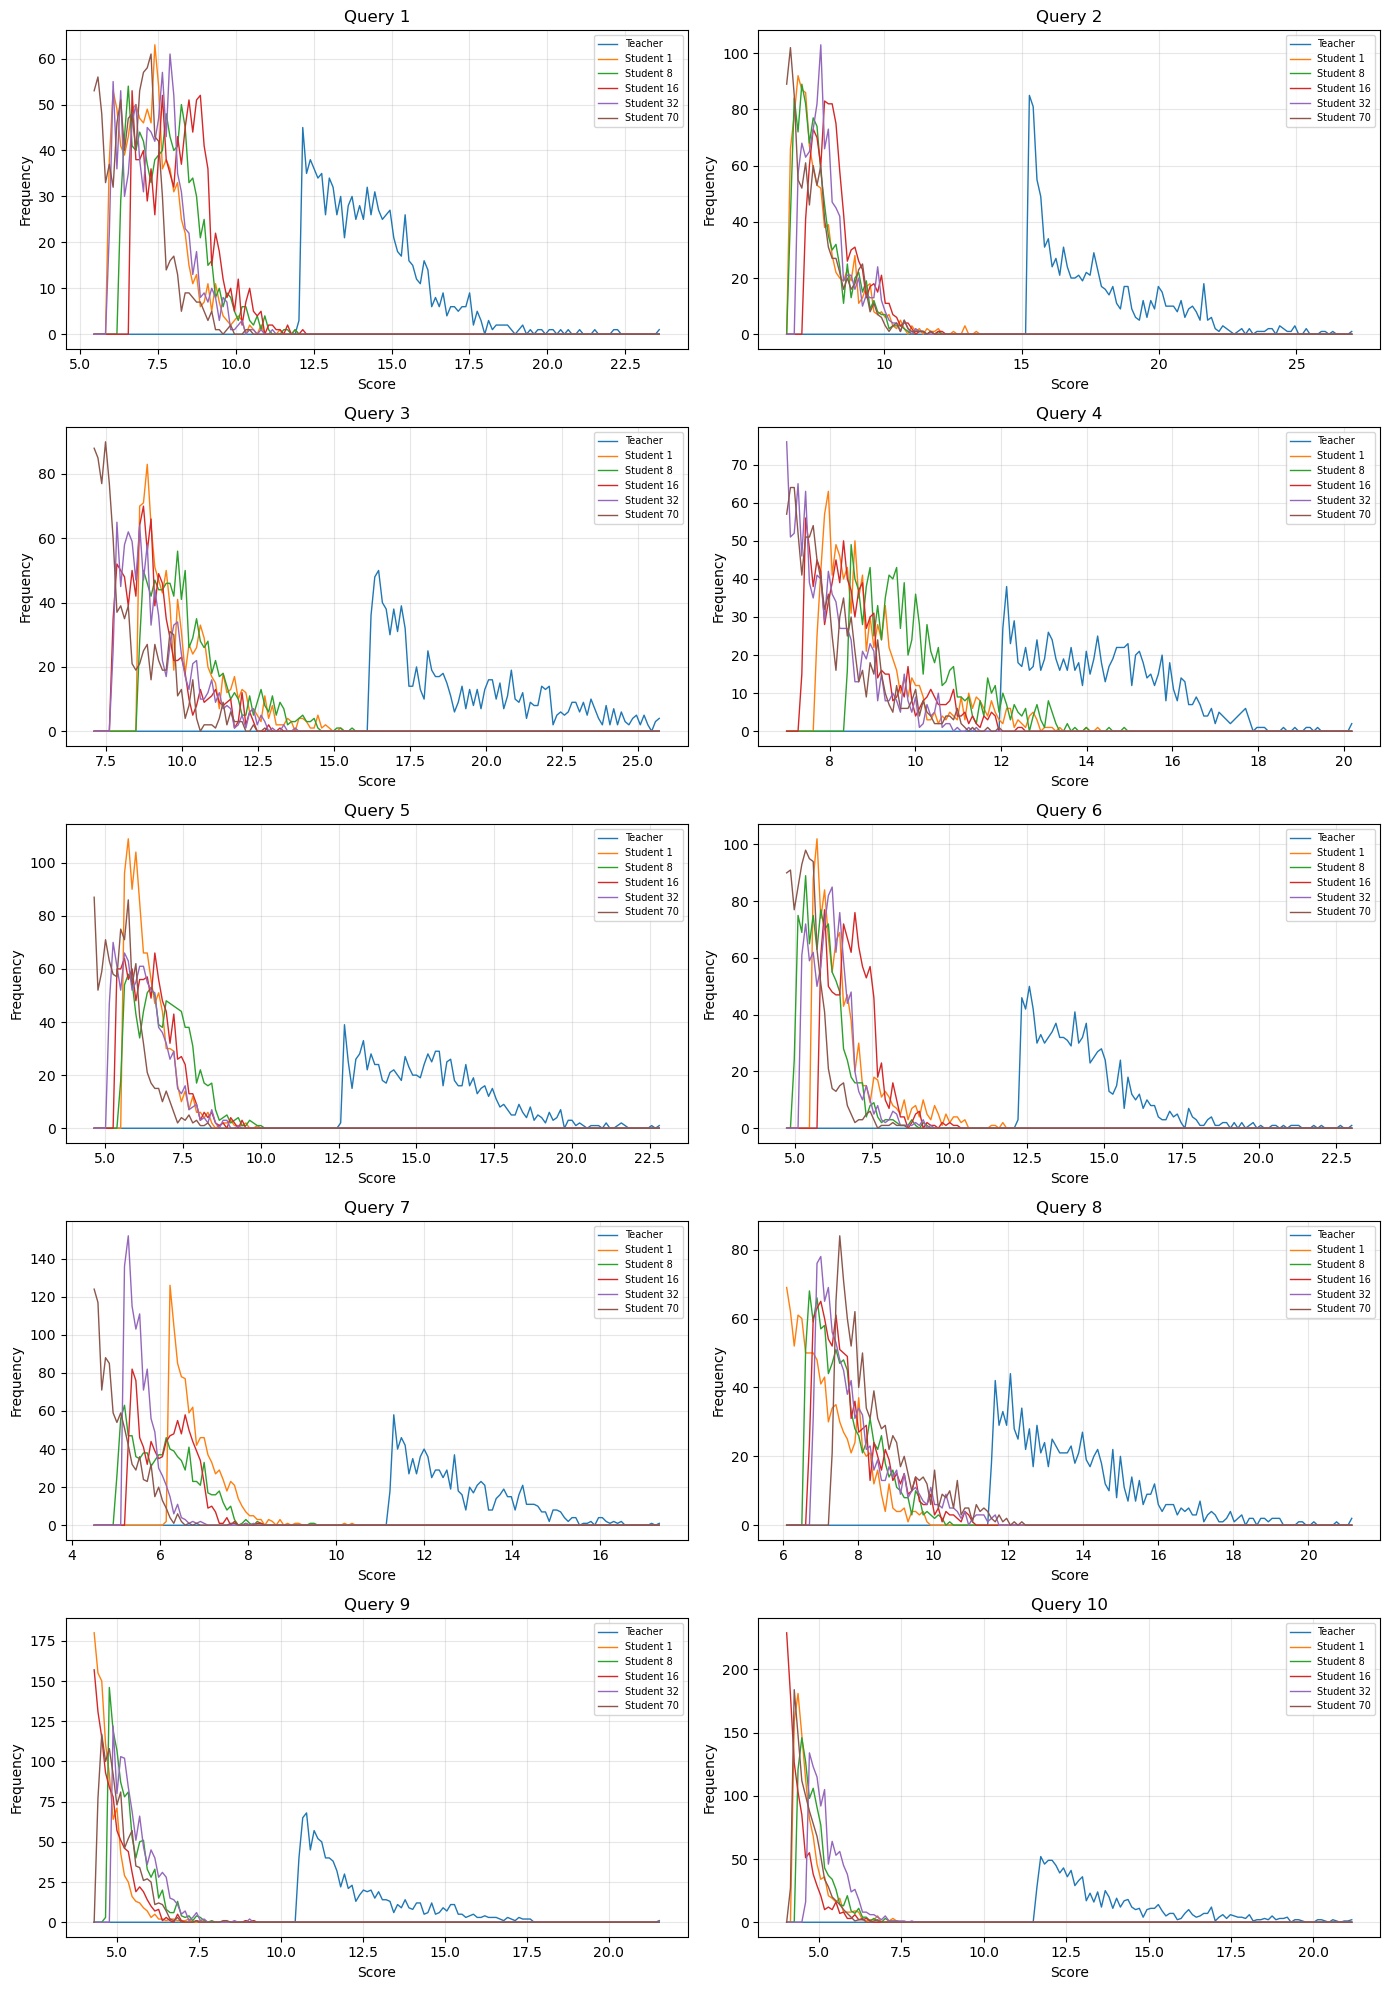

In [46]:
import numpy as np
import matplotlib.pyplot as plt

min_queries = 1
max_queries = 10   # show first 10 queries

# Helper to collect scores for a single query
def get_scores_for_query(i):
    return {
        "Teacher":           np.array(list(teacher_results[str(i)].values()), dtype=float),
        "Student 1":         np.array(list(student_1_results[str(i)].values()), dtype=float),
        "Student 8":         np.array(list(student_8_results[str(i)].values()), dtype=float),
        "Student 16":        np.array(list(student_16_results[str(i)].values()), dtype=float),
        "Student 32":        np.array(list(student_32_results[str(i)].values()), dtype=float),
        "Student 70":        np.array(list(student_70_results[str(i)].values()), dtype=float),
    }

# Prepare figure
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()

num_bins = 150  # many bins for resolution

for idx, query_id in enumerate(range(min_queries, max_queries + 1)):
    ax = axes[idx]
    
    # Collect all scores for this query
    data_dict = get_scores_for_query(query_id)

    # Get global min/max for consistent bins
    q_min = min(arr.min() for arr in data_dict.values())
    q_max = max(arr.max() for arr in data_dict.values())
    bins = np.linspace(q_min, q_max, num_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Plot each model's line-hist
    for name, arr in data_dict.items():
        counts, _ = np.histogram(arr, bins=bins)
        ax.plot(bin_centers, counts, label=name, linewidth=1)

    ax.set_title(f"Query {query_id}", fontsize=12)
    ax.set_xlabel("Score")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
